In [ ]:
import torch #PyTorch for deep learning
import torchvision.transforms as transforms #image transformations
from torchvision.datasets import ImageFolder #Loading images from folders as datasets.
from torch.utils.data import DataLoader #batch processing of datasets.
from transformers import SwinForImageClassification #Swin Transformer model for image classification.
import torch.nn as nn #Neural network modules (for modifying the model).
import torch.optim as optim #Optimization algorithms for training the model.
import os
import timm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns #data visualization
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report #Provides functions to compute classification metrics.
from google.colab import drive  # For Google Drive access
import shutil
import random
import hashlib

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/brain_tumor_dataset"
output_dir = "/content/drive/MyDrive/split_dataset_brain_tumor"  # where the split dataset will be saved

In [ ]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
for split in ["train", "val", "test"]:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    train_split = int(len(images) * train_ratio)
    val_split = int(len(images) * (train_ratio + val_ratio))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "train", class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "val", class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "test", class_name, img))

In [ ]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 (Swin Transformer input size)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize pixel values (-1 to 1)
])

# Load the Dataset
train_dataset = ImageFolder(os.path.join(output_dir, "train"), transform=transform)
val_dataset = ImageFolder(os.path.join(output_dir, "val"), transform=transform)
test_dataset = ImageFolder(os.path.join(output_dir, "test"), transform=transform)

# Create Data Loaders (For Batch Processing)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle->randomizing the dataset for better results
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load Pretrained Swin Transformer
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
num_classes = len(train_dataset.classes)  # Finds the no. of classes from dataset

# Final Classification Layer Modification
model.classifier = nn.Linear(model.classifier.in_features, num_classes) #replace the final classification layer with a new nn.Linear layer that matches the dataset’s classes.
model.to(device)  # Move model to GPU if available

# Loss Function & Optimizer Definition
criterion = nn.CrossEntropyLoss() # Measures how well the model is classifying images.
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Adjusts model weights using a learning rate of 0.0001

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from the untrained model
        outputs = model(images).logits

        # Get the predicted class with highest probability
        _, predicted = torch.max(outputs, 1)

        # Count correctly predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
pre_training_accuracy = 100 * correct / total
print(f"Pre-training Test Accuracy: {pre_training_accuracy:.2f}%")


Pre-training Test Accuracy: 20.04%


In [ ]:
# Training
num_epochs = 7 # Adjust based on results
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Get model predictions
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1/7, Loss: 0.2664, Accuracy: 90.51%
Epoch 2/7, Loss: 0.0626, Accuracy: 97.74%
Epoch 3/7, Loss: 0.0348, Accuracy: 99.03%
Epoch 4/7, Loss: 0.0249, Accuracy: 99.13%
Epoch 5/7, Loss: 0.0295, Accuracy: 99.09%
Epoch 6/7, Loss: 0.0243, Accuracy: 99.25%
Epoch 7/7, Loss: 0.0100, Accuracy: 99.66%


In [ ]:
# Validation
model.eval()
val_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Validation Loss: 0.0517, Accuracy: 98.68%


In [ ]:
# Testing
model.eval()
test_loss, correct, total = 0.0, 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Test Loss: 0.0381, Accuracy: 98.97%


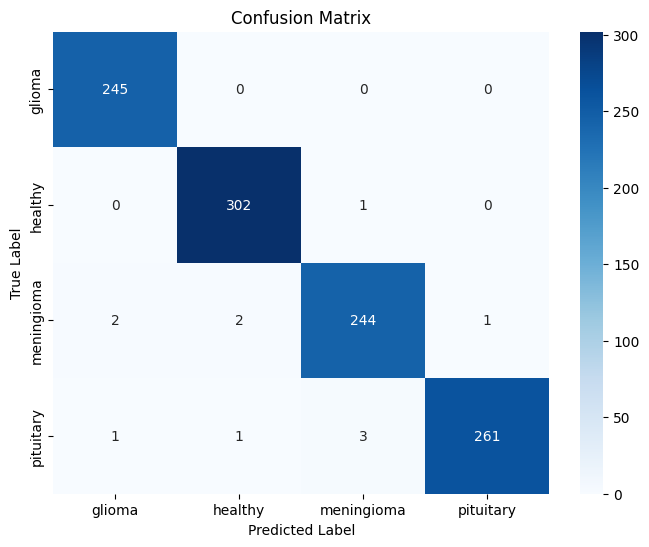

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99       245
     healthy       0.99      1.00      0.99       303
  meningioma       0.98      0.98      0.98       249
   pituitary       1.00      0.98      0.99       266

    accuracy                           0.99      1063
   macro avg       0.99      0.99      0.99      1063
weighted avg       0.99      0.99      0.99      1063



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

In [ ]:
# Save the Trained Model
model_save_path = "/content/swin_brain_tumor_detection.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/swin_brain_tumor_detection.pth
